# Grover's Search Algorithm (3-qubit system)

In [81]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

# Oracle

In [82]:
def oracle(circuit, target_state):
    # Apply X gates to qubits that are '0' in the target state
    for qubit in range(len(target_state)):
        if target_state[qubit] == '0':
            circuit.x(qubit)
    
    # Apply Hadamard, controlled-Z, and Hadamard to the last qubit
    circuit.h(len(target_state) - 1)
    circuit.mcx(list(range(len(target_state) - 1)), len(target_state) - 1)
    circuit.h(len(target_state) - 1)
    
    # Revert the X gates
    for qubit in range(len(target_state)):
        if target_state[qubit] == '0':
            circuit.x(qubit)

# Diffusion operator

In [83]:
def diffuser(circuit, nqubits):
   # Apply Hadamard gates to all qubits
    circuit.h(range(nqubits))
    
    # Apply X gates to all qubits
    circuit.x(range(nqubits))
    
    # Apply Hadamard, controlled-Z, and Hadamard to the last qubit
    circuit.h(nqubits - 1)
    circuit.mcx(list(range(nqubits - 1)), nqubits - 1)
    circuit.h(nqubits - 1)
    
    # Apply X gates to all qubits
    circuit.x(range(nqubits))
    
    # Apply Hadamard gates to all qubits
    circuit.h(range(nqubits))

# Circuit

Configuration

In [84]:
# Number of qubits
nqubits = 3

# Number of qubits
nqubits = 3


Circuit creation

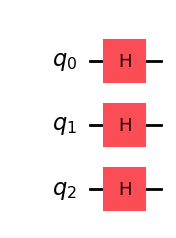

In [85]:
qc = QuantumCircuit(nqubits)


# Apply Hadamard gates to all qubits to create superposition
qc.h(range(nqubits))

qc.draw('mpl')

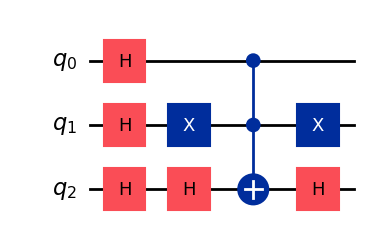

In [86]:
# Define the target state (binary string)
target_state = '101'

# Apply the oracle
oracle(qc, target_state)

qc.draw('mpl')

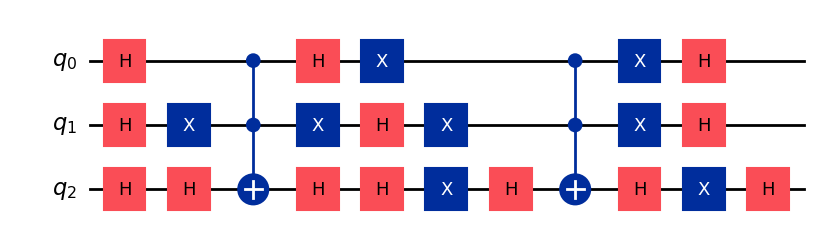

In [87]:
# Apply the diffuser
diffuser(qc, nqubits)

qc.draw('mpl')

Grover's iterate - 2 iterations total

In [88]:
oracle(qc, target_state)
diffuser(qc, nqubits)

Measurement

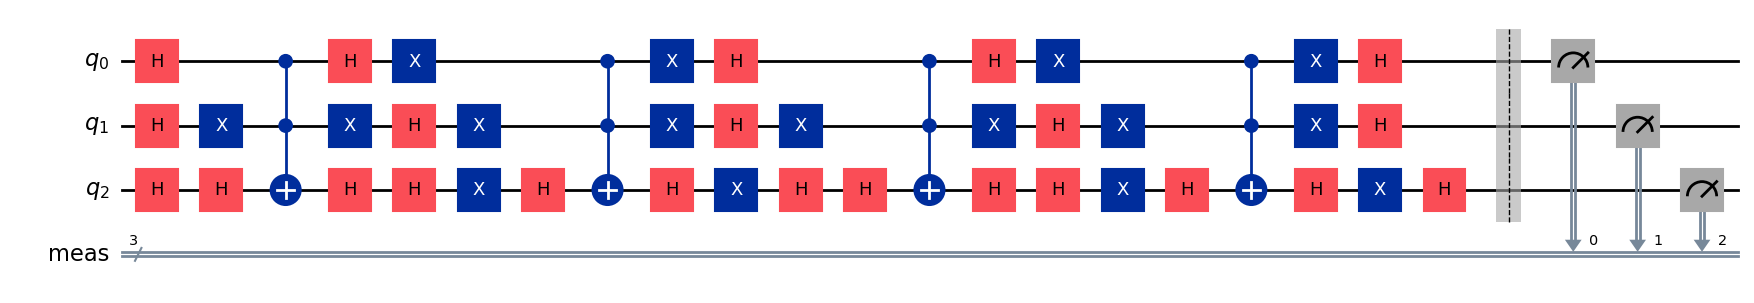

In [89]:
# Measure the qubits
qc.measure_all()

# Draw the circuit
qc.draw('mpl')

# Circult simulation with QASM

In [90]:
# Use the Aer's qasm_simulator
simulator = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator
circuit = transpile(qc, simulator)
job = simulator.run(circuit, shots=1000)


In [91]:
# Grab results from the job
result = job.result()
counts = result.get_counts()
print("\nTotal count for 0 and 1 are:",counts)


Total count for 0 and 1 are: {'110': 10, '001': 11, '100': 15, '011': 7, '111': 6, '010': 5, '000': 10, '101': 936}


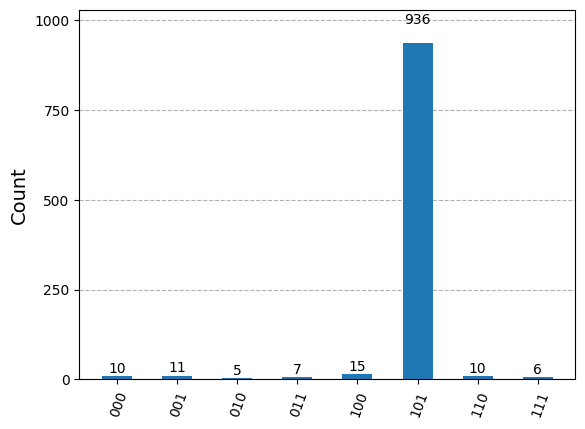

In [92]:
# Plot the histogram of the results
plot_histogram(counts)

# Simulation with IBM Quantum Computer

In [93]:
# To run on hardware
service = QiskitRuntimeService(channel="ibm_quantum")

# Select the backend with the fewest number of jobs in the queue
backend = service.least_busy(operational=True, simulator=False)

# Display the backend name
backend.name

'ibm_kyoto'

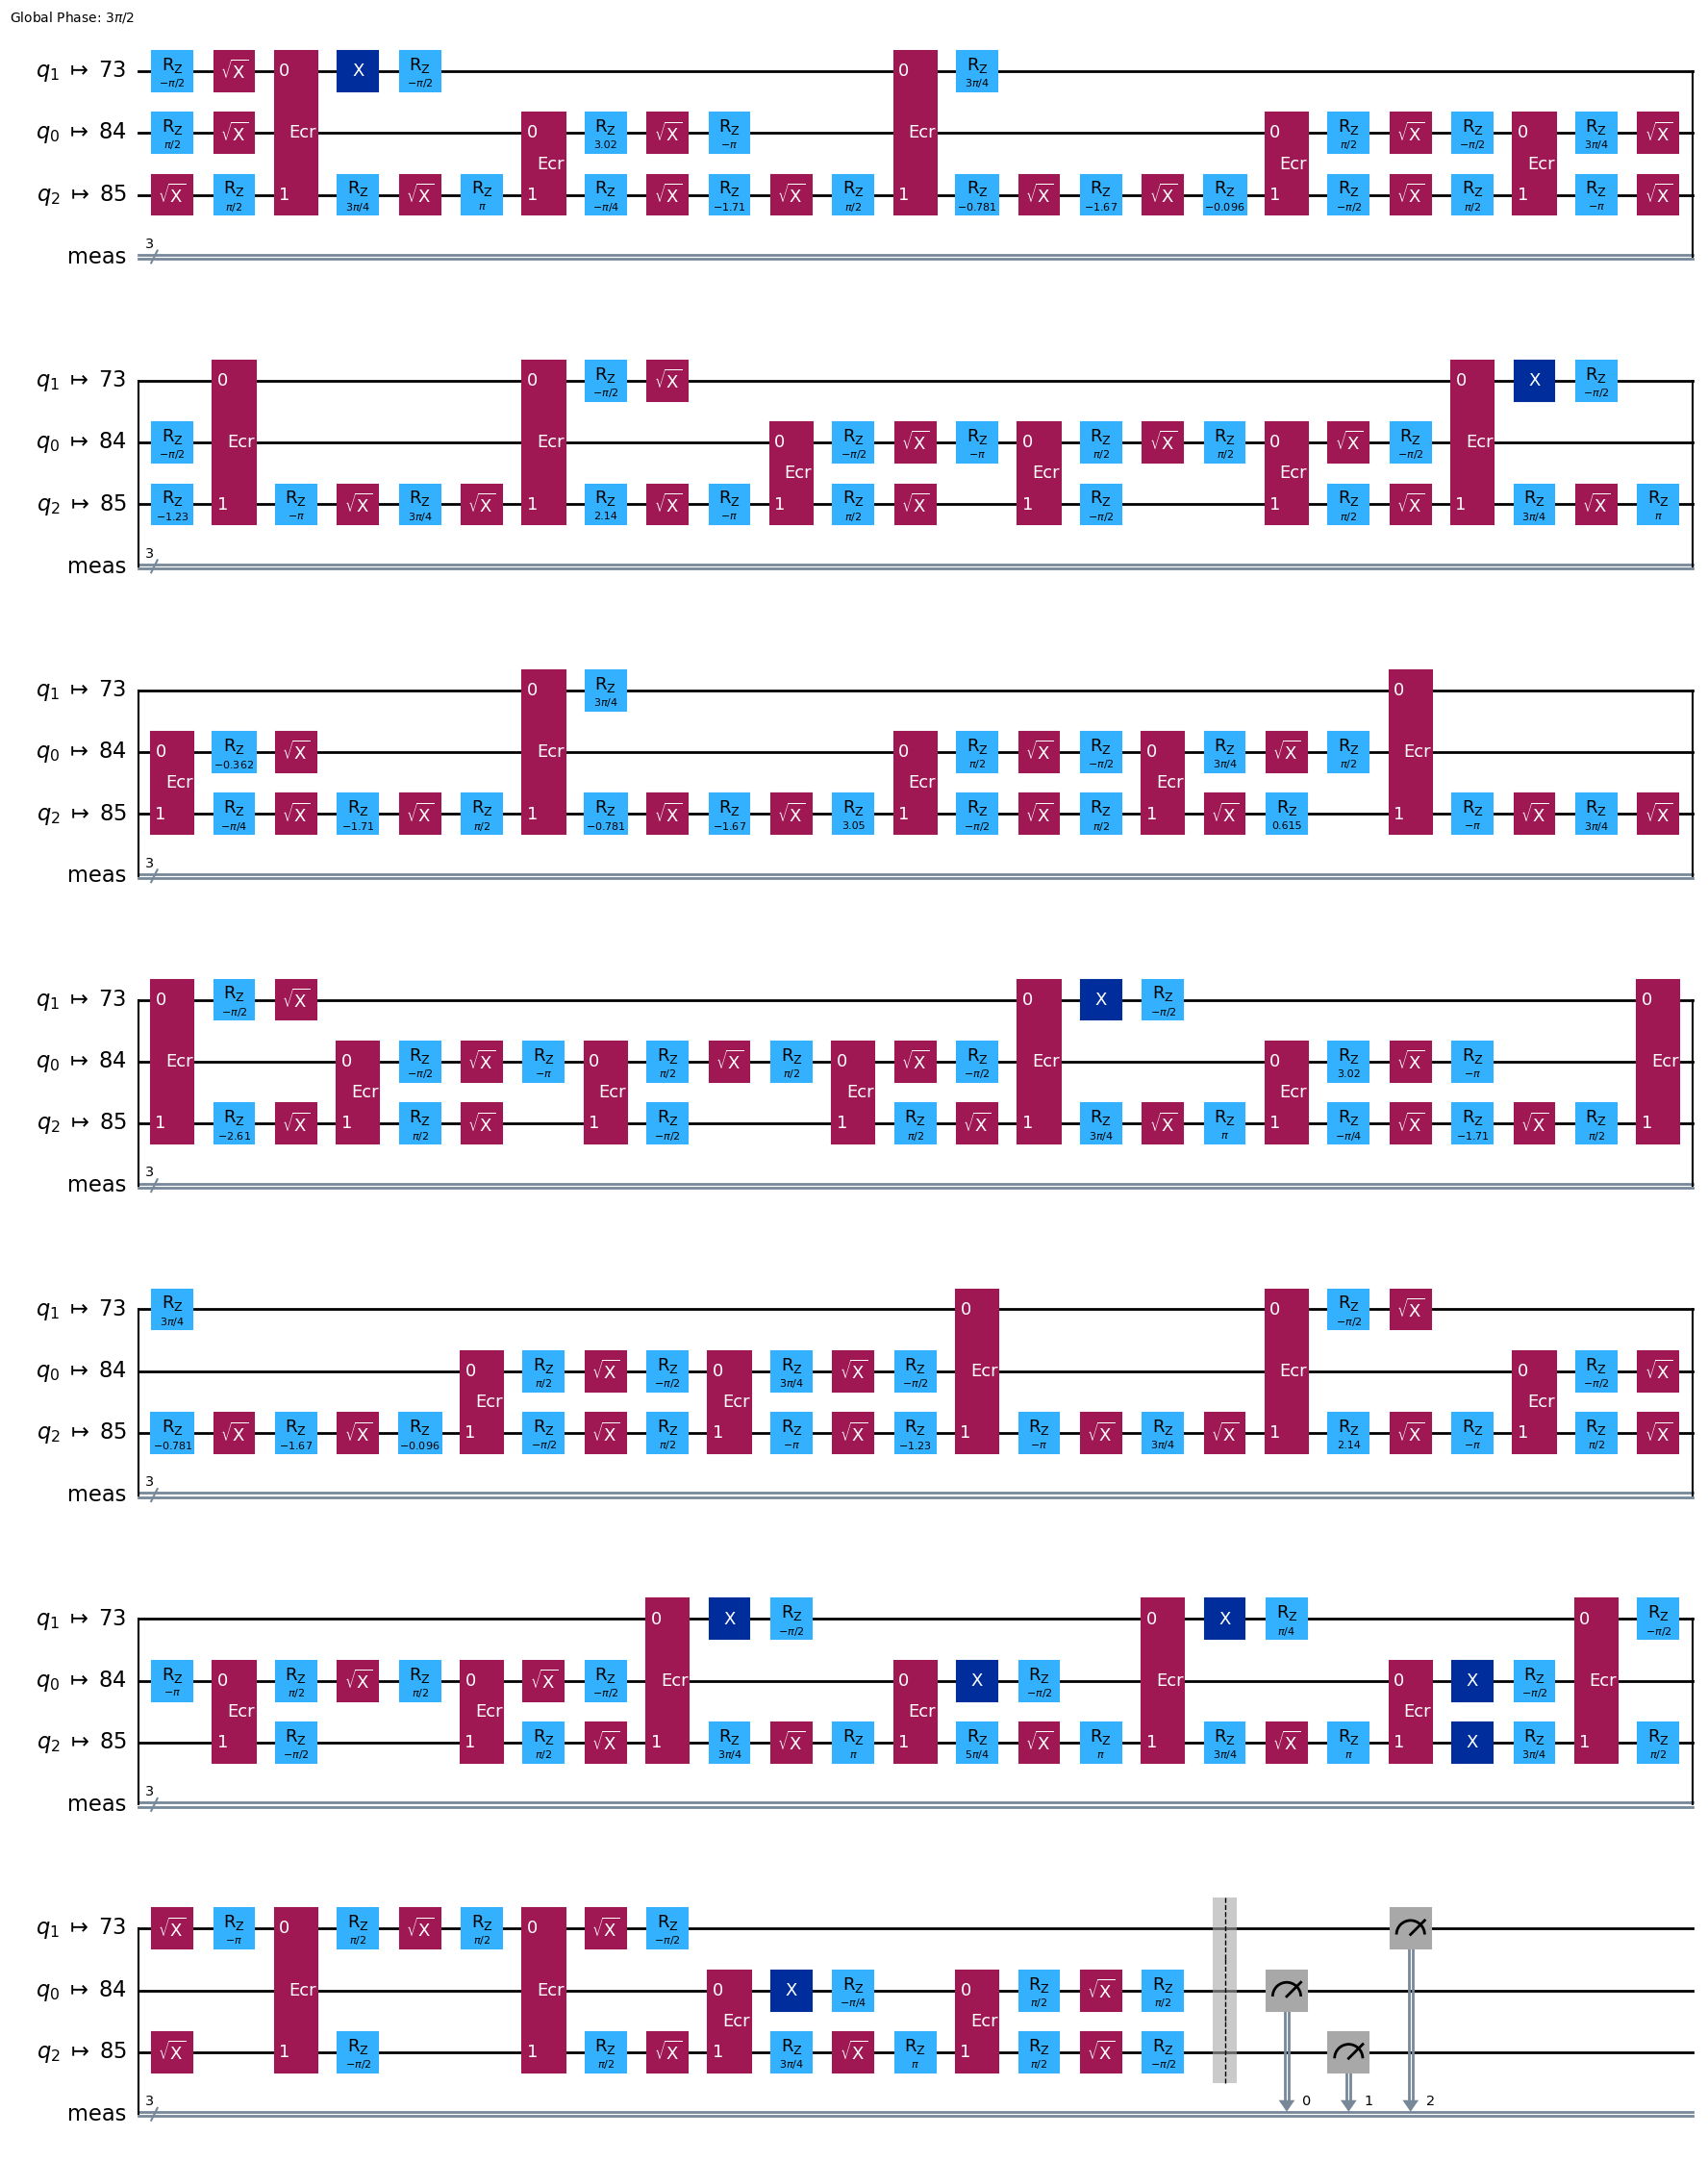

In [94]:
target = backend.target

# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [96]:
# Optimize the circuit for the target backend
transpiled_gc = transpile(qc, backend, optimization_level=3)

# Execute the transpiled circuit on the backend
job = backend.run(transpiled_gc, shots=8192)

/var/folders/kd/9h3yrkps2vj0t9zs17vt349c0000gn/T/ipykernel_63891/2955025515.py:5: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  job = backend.run(transpiled_gc, shots=8192)


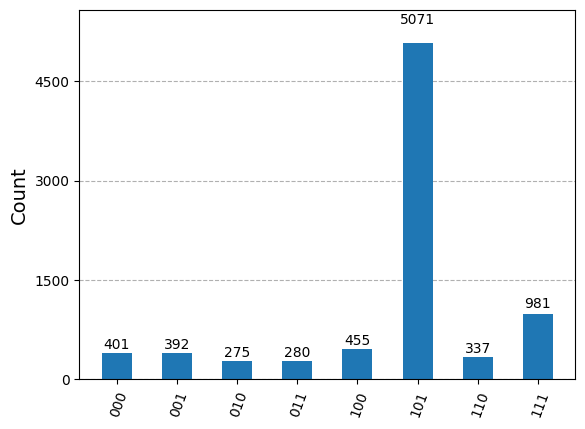

In [97]:
# Retrieve the result
result = job.result()
counts = result.get_counts()

# Plot the histogram of results
plot_histogram(counts)